## 统计数据集QA对

In [1]:
import json
import os
from collections import defaultdict

# 计算QA文件夹下所有json中平均QA对, 计算三个事件分别的数量，以及future、full、past QA对数量
def calculate_avg_qa_pairs(folder_path):
    total_qa_pairs = 0
    num_files = 0
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                total_qa_pairs += len(data)
                num_files += 1
    if num_files > 0:
        avg_qa_pairs = total_qa_pairs / num_files
        return avg_qa_pairs, num_files, total_qa_pairs
    else:
        return 0
# 示例用法
folder_path = './First_Half_QA'
avg_qa_pairs = calculate_avg_qa_pairs(folder_path)
print(f"平均QA对数量: {avg_qa_pairs}")

# 计算goal, yellow_card, corner分别的数量，以及future、full、past QA对数量
def calculate_event_qa_pairs(folder_path):
    event_qa_pairs = defaultdict(int)
    num_files = 0
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                for qa_pair in data:
                    event_type = qa_pair.get('event_type')
                    qa_time = qa_pair.get('type')
                    event_qa_pairs[event_type] += 1
                    event_qa_pairs[qa_time] += 1
                num_files += 1
    return event_qa_pairs, num_files
# 示例用法
folder_path = './First_Half_QA'
event_qa_pairs, num_files = calculate_event_qa_pairs(folder_path)
print(f"事件QA对数量: {event_qa_pairs}")

平均QA对数量: (25.05263157894737, 57, 1428)
事件QA对数量: defaultdict(<class 'int'>, {'goal': 416, 'past': 551, 'half': 410, 'future': 467, 'corner': 674, 'yellow card': 338})


## 统计平均clip长度

### end - start

In [3]:
import os
import json
import subprocess
import argparse
import datetime
from tqdm import tqdm
import concurrent.futures  # Added for threading


def load_json(filepath):
    """Loads data from a JSON file."""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Error: File not found - {filepath}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from file - {filepath}")
        return None


def parse_timestamp_to_seconds(timestamp_str):
    """Converts MM:SS timestamp string to total seconds."""
    try:
        minutes, seconds = map(int, timestamp_str.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        print(
            f"Error: Invalid timestamp format - {timestamp_str}. Expected MM:SS.")
        return None


def get_event_timestamp(match_data, event_index):
    """Retrieves the timestamp (in seconds) for a given event index."""
    if match_data and 0 <= event_index < len(match_data.get('comments', [])):
        timestamp_str = match_data['comments'][event_index].get('time_stamp')
        if timestamp_str:
            return parse_timestamp_to_seconds(timestamp_str)
    return None


def find_previous_event_timestamp(match_data, current_index, event_type):
    """Finds the timestamp (in seconds) of the previous event of the same type."""
    if not match_data or not match_data.get('comments'):
        return None
    previous_timestamp_sec = None
    comments = match_data.get('comments', [])
    for i in range(current_index - 1, -1, -1):
        if i < len(comments) and comments[i].get('comments_type') == event_type:
            timestamp_str = comments[i].get("time_stamp")
            if timestamp_str:
                previous_timestamp_sec = parse_timestamp_to_seconds(
                    timestamp_str)
                if previous_timestamp_sec is not None:
                    break  # Found a valid previous timestamp
            else:
                print(
                    f"Warning: Missing 'time_stamp' for event index {i} while searching for previous event.")

    return previous_timestamp_sec


def format_time(seconds):
    """Converts seconds into HH:MM:SS.ms format for ffmpeg."""
    if seconds < 0:
        seconds = 0
    delta = datetime.timedelta(seconds=seconds)
    hours, remainder = divmod(delta.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    milliseconds = delta.microseconds // 1000
    return f"{hours:02}:{minutes:02}:{seconds:02}.{milliseconds:03}"


def process_qa_files(qa_dir, match_dir, raw_match_dir, output_dir):
    """处理所有 QA 文件并计算视频剪辑长度。"""
    qa_files = [f for f in os.listdir(qa_dir) if f.endswith('.json')]
    if not qa_files:
        print(f"在目录 {qa_dir} 中未找到 JSON 文件。")
        return []

    video_clip_lens = []
    print("准备剪辑视频长度列表...")

    # 遍历所有 QA 文件
    for qa_filename in tqdm(qa_files, desc="读取 QA 文件并准备剪辑长度"):
        qa_filepath = os.path.join(qa_dir, qa_filename)
        qa_data = load_json(qa_filepath)
        if not qa_data:
            print(f"警告：无法加载或空的 QA 文件：{qa_filename}")
            continue

        match_name, _ = os.path.splitext(qa_filename)
        match_subdir_path = os.path.join(match_dir, match_name)

        if not os.path.isdir(match_subdir_path):
            print(f"跳过 {match_name}：未找到比赛数据目录 - {match_subdir_path}")
            continue

        match_json_files = [f for f in os.listdir(
            match_subdir_path) if f.endswith('.json')]
        if not match_json_files:
            print(f"跳过 {match_name}：在 {match_subdir_path} 中未找到 JSON 文件")
            continue
        match_filename = match_json_files[0]
        match_filepath = os.path.join(match_subdir_path, match_filename)
        match_data = load_json(match_filepath)
        if not match_data:
            print(f"跳过 {match_name}：比赛数据无效或未找到。")
            continue

        raw_match_filename = f"{match_name.split('_')[1]}_1.mkv"
        raw_match_video_dir = os.path.join(raw_match_dir, match_name)
        raw_match_filepath = os.path.join(
            raw_match_video_dir, raw_match_filename)

        if not os.path.exists(raw_match_filepath):
            print(f"跳过 {match_name}：未找到原始比赛文件 - {raw_match_filepath}")
            continue

        match_output_dir = os.path.join(output_dir, match_name)
        os.makedirs(match_output_dir, exist_ok=True)

        for i, qa_pair in enumerate(qa_data):
            event_type = qa_pair.get('event_type')
            question_type = qa_pair.get('type')
            current_event_index = qa_pair.get('current_event_index')
            related_event_indices = qa_pair.get('related_event_index', [])

            if event_type is None or current_event_index is None:
                continue

            current_event_timestamp = get_event_timestamp(
                match_data, current_event_index)
            if current_event_timestamp is None:
                continue

            start_time_sec = None
            end_time_sec = current_event_timestamp + 15

            if question_type in ['past', 'half']:
                if not related_event_indices:
                    continue
                min_related_index = min(related_event_indices)
                min_related_event_timestamp = get_event_timestamp(
                    match_data, min_related_index)
                if min_related_event_timestamp is None:
                    continue
                start_time_sec = min_related_event_timestamp - 15

            elif question_type == 'future':
                prev_event_timestamp = find_previous_event_timestamp(
                    match_data, current_event_index, event_type)
                if prev_event_timestamp is None:
                    continue
                start_time_sec = prev_event_timestamp - 15
            else:
                continue  # 跳过未知类型

            if start_time_sec is None:
                continue

            start_time_sec = max(0, start_time_sec)
            duration_sec = end_time_sec - start_time_sec

            if duration_sec <= 0:  # 检查持续时间是否有效
                continue

            output_filename = f"{match_name}_{event_type}_{qa_pair.get('index')}.mp4"
            output_filepath = os.path.join(match_output_dir, output_filename)

            # 添加剪辑持续时间到列表
            video_clip_lens.append(duration_sec)
    return video_clip_lens


qa_dir = '/DB/data/jiayuanrao-1/sports/haokai_intern/Dataset/Long-Video-QA/Tiny_QA/First_Half_QA'
match_dir = '/DB/data/jiayuanrao-1/sports/haokai_intern/Dataset/Long-Video-QA/Tiny_QA/Subject_Data'
raw_match_dir = '/DB/data/jiayuanrao-1/sports/haokai_intern/Dataset/SoccerReplay-1988/Raw_match/england_epl_2017-2018'
output_dir = '/DB/data/jiayuanrao-1/sports/haokai_intern/Dataset/Long-Video-QA/Tiny_QA/clips'

# 调用 process_qa_files 函数并计算视频剪辑长度
video_clip_lens = process_qa_files(
    qa_dir, match_dir, raw_match_dir, output_dir)

准备剪辑视频长度列表...


读取 QA 文件并准备剪辑长度: 100%|██████████| 57/57 [00:00<00:00, 1020.71it/s]


In [4]:
import numpy as np
video_clip_lens = np.array(video_clip_lens)

(array([415.,  48.,  38.,  33.,  38.,  29.,  32.,   9.,  18.,   1.,  11.,
         10.,  10.,   7.,   3.,   3.,   6.,   0.,   3.,   3.]),
 array([   8.  ,  128.15,  248.3 ,  368.45,  488.6 ,  608.75,  728.9 ,
         849.05,  969.2 , 1089.35, 1209.5 , 1329.65, 1449.8 , 1569.95,
        1690.1 , 1810.25, 1930.4 , 2050.55, 2170.7 , 2290.85, 2411.  ]),
 <BarContainer object of 20 artists>)

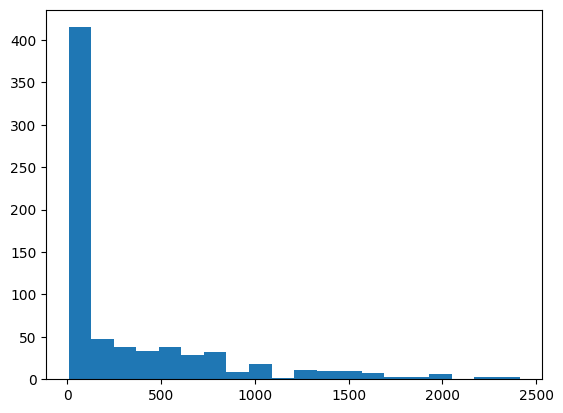

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(video_clip_lens, bins=20)

In [10]:
sum(np.where(video_clip_lens==30, 1, 0))

np.int64(360)

### end

In [5]:
import os
import json
import subprocess
import argparse
import datetime
from tqdm import tqdm
import concurrent.futures  # Added for threading


def load_json(filepath):
    """Loads data from a JSON file."""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Error: File not found - {filepath}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from file - {filepath}")
        return None


def parse_timestamp_to_seconds(timestamp_str):
    """Converts MM:SS timestamp string to total seconds."""
    try:
        minutes, seconds = map(int, timestamp_str.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        print(
            f"Error: Invalid timestamp format - {timestamp_str}. Expected MM:SS.")
        return None


def get_event_timestamp(match_data, event_index):
    """Retrieves the timestamp (in seconds) for a given event index."""
    if match_data and 0 <= event_index < len(match_data.get('comments', [])):
        timestamp_str = match_data['comments'][event_index].get('time_stamp')
        if timestamp_str:
            return parse_timestamp_to_seconds(timestamp_str)
    return None


def find_previous_event_timestamp(match_data, current_index, event_type):
    """Finds the timestamp (in seconds) of the previous event of the same type."""
    if not match_data or not match_data.get('comments'):
        return None
    previous_timestamp_sec = None
    comments = match_data.get('comments', [])
    for i in range(current_index - 1, -1, -1):
        if i < len(comments) and comments[i].get('comments_type') == event_type:
            timestamp_str = comments[i].get("time_stamp")
            if timestamp_str:
                previous_timestamp_sec = parse_timestamp_to_seconds(
                    timestamp_str)
                if previous_timestamp_sec is not None:
                    break  # Found a valid previous timestamp
            else:
                print(
                    f"Warning: Missing 'time_stamp' for event index {i} while searching for previous event.")

    return previous_timestamp_sec


def format_time(seconds):
    """Converts seconds into HH:MM:SS.ms format for ffmpeg."""
    if seconds < 0:
        seconds = 0
    delta = datetime.timedelta(seconds=seconds)
    hours, remainder = divmod(delta.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    milliseconds = delta.microseconds // 1000
    return f"{hours:02}:{minutes:02}:{seconds:02}.{milliseconds:03}"


def process_qa_files(qa_dir, match_dir, raw_match_dir, output_dir):
    """处理所有 QA 文件并计算视频剪辑长度。"""
    qa_files = [f for f in os.listdir(qa_dir) if f.endswith('.json')]
    if not qa_files:
        print(f"在目录 {qa_dir} 中未找到 JSON 文件。")
        return []

    video_clip_lens = []
    print("准备剪辑视频长度列表...")

    # 遍历所有 QA 文件
    for qa_filename in tqdm(qa_files, desc="读取 QA 文件并准备剪辑长度"):
        qa_filepath = os.path.join(qa_dir, qa_filename)
        qa_data = load_json(qa_filepath)
        if not qa_data:
            print(f"警告：无法加载或空的 QA 文件：{qa_filename}")
            continue

        match_name, _ = os.path.splitext(qa_filename)
        match_subdir_path = os.path.join(match_dir, match_name)

        if not os.path.isdir(match_subdir_path):
            print(f"跳过 {match_name}：未找到比赛数据目录 - {match_subdir_path}")
            continue

        match_json_files = [f for f in os.listdir(
            match_subdir_path) if f.endswith('.json')]
        if not match_json_files:
            print(f"跳过 {match_name}：在 {match_subdir_path} 中未找到 JSON 文件")
            continue
        match_filename = match_json_files[0]
        match_filepath = os.path.join(match_subdir_path, match_filename)
        match_data = load_json(match_filepath)
        if not match_data:
            print(f"跳过 {match_name}：比赛数据无效或未找到。")
            continue

        raw_match_filename = f"{match_name.split('_')[1]}_1.mkv"
        raw_match_video_dir = os.path.join(raw_match_dir, match_name)
        raw_match_filepath = os.path.join(
            raw_match_video_dir, raw_match_filename)

        if not os.path.exists(raw_match_filepath):
            print(f"跳过 {match_name}：未找到原始比赛文件 - {raw_match_filepath}")
            continue

        match_output_dir = os.path.join(output_dir, match_name)
        os.makedirs(match_output_dir, exist_ok=True)

        for i, qa_pair in enumerate(qa_data):
            event_type = qa_pair.get('event_type')
            question_type = qa_pair.get('type')
            current_event_index = qa_pair.get('current_event_index')
            related_event_indices = qa_pair.get('related_event_index', [])

            if event_type is None or current_event_index is None:
                continue

            current_event_timestamp = get_event_timestamp(
                match_data, current_event_index)
            if current_event_timestamp is None:
                continue

            start_time_sec = None
            end_time_sec = current_event_timestamp + 15

            if question_type in ['past', 'half']:
                if not related_event_indices:
                    continue
                min_related_index = min(related_event_indices)
                min_related_event_timestamp = get_event_timestamp(
                    match_data, min_related_index)
                if min_related_event_timestamp is None:
                    continue
                start_time_sec = min_related_event_timestamp - 15

            elif question_type == 'future':
                prev_event_timestamp = find_previous_event_timestamp(
                    match_data, current_event_index, event_type)
                if prev_event_timestamp is None:
                    continue
                start_time_sec = prev_event_timestamp - 15
            else:
                continue  # 跳过未知类型

            if start_time_sec is None:
                continue

            start_time_sec = max(0, start_time_sec)
            duration_sec = end_time_sec - start_time_sec

            if duration_sec <= 0:  # 检查持续时间是否有效
                continue

            output_filename = f"{match_name}_{event_type}_{qa_pair.get('index')}.mp4"
            output_filepath = os.path.join(match_output_dir, output_filename)

            # 添加剪辑持续时间到列表
            video_clip_lens.append(end_time_sec)
    return video_clip_lens


qa_dir = './First_Half_QA'
match_dir = './Subject_Data'
raw_match_dir = '../../SoccerReplay-1988/Raw_match/england_epl_2017-2018'
output_dir = './clips'

# 调用 process_qa_files 函数并计算视频剪辑长度
video_clip_lens = process_qa_files(
    qa_dir, match_dir, raw_match_dir, output_dir)

准备剪辑视频长度列表...


读取 QA 文件并准备剪辑长度: 100%|██████████| 57/57 [00:00<00:00, 2088.43it/s]


(array([35., 38., 71., 16., 34., 54., 28., 61., 41., 37., 55., 26., 42.,
        33., 34., 37., 34., 10., 12., 19.]),
 array([  53. ,  189.6,  326.2,  462.8,  599.4,  736. ,  872.6, 1009.2,
        1145.8, 1282.4, 1419. , 1555.6, 1692.2, 1828.8, 1965.4, 2102. ,
        2238.6, 2375.2, 2511.8, 2648.4, 2785. ]),
 <BarContainer object of 20 artists>)

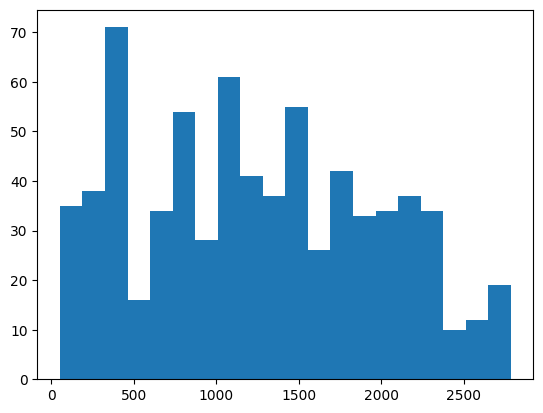

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(video_clip_lens, bins=20)

## 处理clips

### 查看原本视频分辨率

In [8]:
# 查看/DB/data/jiayuanrao-1/sports/haokai_intern/Dataset/Long-Video-QA/Tiny_QA/clips/2017-08-12_watford-fc-liverpool-fc/2017-08-12_watford-fc-liverpool-fc_corner_0.mp4视频分辨率
import cv2
video_path = '/DB/data/jiayuanrao-1/sports/haokai_intern/Dataset/Long-Video-QA/Tiny_QA/clips/2018-03-31_everton-fc-manchester-city-premier-league/2018-03-31_everton-fc-manchester-city-premier-league_goal_3.mp4'
cap = cv2.VideoCapture(video_path)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width, height

(640.0, 360.0)

### 查看resize后视频

#### 分辨率

In [5]:
# 查看/DB/data/jiayuanrao-1/sports/haokai_intern/Dataset/Long-Video-QA/Tiny_QA/clips/2017-08-12_watford-fc-liverpool-fc/2017-08-12_watford-fc-liverpool-fc_corner_0.mp4视频分辨率
import cv2
video_path = '/DB/data/jiayuanrao-1/sports/haokai_intern/Dataset/Long-Video-QA/Tiny_QA/clips_resized/2018-03-31_everton-fc-manchester-city-premier-league/2018-03-31_everton-fc-manchester-city-premier-league_goal_3.mp4'
cap = cv2.VideoCapture(video_path)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width, height

(224.0, 224.0)

#### 数量是否正确

In [8]:
# 递归查看文件夹下mp4文件数量
import os
path = './clips_resized/'
count = 0
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.mp4'):
            count += 1
            
count   

1428

#### 文件是否损坏

In [9]:
# 写代码查看./clips_resized文件夹下mp4文件有没有大小为0的文件

import os
import cv2
def check_zero_size_mp4_files(directory):
    zero_size_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.mp4'):
                file_path = os.path.join(root, file)
                file_size = os.path.getsize(file_path)
                if file_size == 0:
                    zero_size_files.append(file_path)
                    continue
    return zero_size_files

directory = './clips_resized'
check_zero_size_mp4_files(directory)

[]

#### 能否正确读取

In [10]:
import cv2
video_path = './clips_resized_new/2018-02-11_huddersfield-town-afc-bournemouth/2018-02-11_huddersfield-town-afc-bournemouth_corner_0.mp4'
cap = cv2.VideoCapture(video_path)

### 查看再次筛选过的视频

#### 数量

In [10]:
# 递归查看文件夹下mp4文件数量
import os
path = './clips/tiny_clips_resized/'
count = 0
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.mp4'):
            count += 1
            
count   

188

### 根据tiny数据集clip构建QA对

#### 操作

In [7]:
import os

def extract_qa_for_sampled_clips(qa_dir, tiny_clips_dir, output_base_dir):
    for match in os.listdir(tiny_clips_dir):
        new_qa = []
        qa_file_path = os.path.join(qa_dir, match + '.json')
        if not os.path.exists(qa_file_path):
            print(f"QA file not found for match: {match}")
            continue
        with open(qa_file_path, 'r', encoding='utf-8') as f:
            qa_data = json.load(f)
            for clip in os.listdir(os.path.join(tiny_clips_dir, match)):
                *_, event_type, index = os.path.splitext(clip)[0].split('_')
                for qa in qa_data:
                    if qa['event_type'] == event_type and qa['index'] == int(index):
                        new_qa.append(qa)
        with open(os.path.join(output_base_dir, match + '.json'), 'w', encoding='utf-8') as f:
            json.dump(new_qa, f, ensure_ascii=False, indent=2)

qa_dir = './First_Half_QA'
tiny_clips_dir = './clips/tiny_clips_resized/'
output_base_dir = './Tiny_First_Half_QA'
extract_qa_for_sampled_clips(qa_dir, tiny_clips_dir, output_base_dir)


#### 检查

In [11]:
import os
count = 0
for qa in os.listdir('./Tiny_First_Half_QA'):
    with open(os.path.join('./Tiny_First_Half_QA', qa), 'r', encoding='utf-8') as f:
        data = json.load(f)
        count += len(data)
count


188

In [15]:
import math

def smart_nframes(total_frames, video_fps, fps=1.0, min_frames=4, max_frames=576, frame_factor=2):
    """Calculate the number of frames that should be extracted from the video

    Args:
        total_frames: Total number of frames in the video
        video_fps: Original video frame rate
        fps: Target frame rate for extraction, default 1.0
        min_frames: Minimum number of frames, default 4
        max_frames: Maximum number of frames, default 576
        frame_factor: Frame factor to make frame count a multiple of this value, default 2

    Returns:
        int: Calculated number of frames to extract
    """
    # Round up to multiple of frame_factor
    def ceil_by_factor(n, f): return math.ceil(n / f) * f
    # Round down to multiple of frame_factor 
    def floor_by_factor(n, f): return math.floor(n / f) * f
    # Round to nearest multiple of frame_factor
    def round_by_factor(n, f): return round(n / f) * f

    # Calculate ideal frame count based on target fps
    nframes = total_frames / video_fps * fps

    # Ensure frame count is within limits
    min_frames = ceil_by_factor(min_frames, frame_factor)
    max_frames = min(floor_by_factor(max_frames, frame_factor), total_frames) 
    nframes = min(min(max(nframes, min_frames), max_frames), total_frames)
    nframes = floor_by_factor(nframes, frame_factor)

    # Ensure result is within valid range
    if not (frame_factor <= nframes and nframes <= total_frames):
        nframes = max(frame_factor, min(total_frames, nframes))
        nframes = floor_by_factor(nframes, frame_factor)

    return int(nframes)


total_frames = 2400
video_fps = 1
smart_nframes(total_frames, video_fps)

576

## 有关QA

### 测试shuffle功能

In [1]:
from collections import Counter
import random


def evaluate_single_qa(qa, shuffle_choices=True, shuffle_times=4):
    """
    Evaluate a single QA pair with optional choice shuffling and voting.

    Args:
        qa (dict): The QA dictionary containing question, choices, answer, etc.
        shuffle_choices (bool): Whether to shuffle the choices during evaluation.
        shuffle_times (int): Number of times to shuffle the choices for voting.

    Returns:
        dict: Evaluation result including model answers, correctness, and optionally shuffle results.
    """
    answers = []
    correct_count = 0

    if not shuffle_choices:
        # Simulate model answering without shuffling
        model_answer = "A"  # Replace this with actual model inference logic
        correct = model_answer == qa['answer']

        return {
            'model_answer': model_answer,
            'correct': correct
        }
    else:
        # Shuffle choices multiple times and simulate model answering
        original_choices = qa['choices'][:]
        for seed in range(shuffle_times):
            shuffled_choices = original_choices.copy()
            random.Random(seed).shuffle(shuffled_choices)

            # Build label mapping from original labels (e.g., A/B/C/D) to new positions
            label_map = {}
            for idx, choice in enumerate(shuffled_choices):
                # Extract the original label (A, B, C, D)
                original_label = choice[0]
                new_label = chr(ord('A') + idx)
                label_map[original_label] = new_label

            # Update the correct answer based on the shuffled order
            shuffled_answer = label_map[qa['answer']]

            # Reassign labels A/B/C/D to the shuffled options
            new_choices = [f"{chr(ord('A') + i)}. {c[3:]}" for i,
                           c in enumerate(shuffled_choices)]

        return new_choices, shuffled_answer


# 示例 QA 数据
qa_example = {
    "question": "Will there be more corners in the first half?",
    "choices": [
        "A. Yes",
        "B. No"
    ],
    "answer": "A",
    "type": "future",
    "question_level": "match",
    "related_event_index": [6, 7],
    "current_event_index": 0,
    "index": 3,
    "event_type": "corner"
}

# 测试调用
result = evaluate_single_qa(qa_example, shuffle_choices=True, shuffle_times=4)
result

(['A. No', 'B. Yes'], 'B')

### 统计30s以上QA的结果

In [3]:
def filter_and_recalculate_stats(json_file_path, output_dir=None, video_clip_dir=None, min_duration=30):
    """
    过滤掉指定秒数以下的视频的QA对，重新计算统计结果
    
    Args:
        json_file_path: shuffle_results.json文件路径
        output_dir: 输出目录，默认为原文件所在目录下的filtered_results
        video_clip_dir: 视频剪辑目录，用于检查视频长度（如果提供）
        min_duration: 视频时长的最小阈值（秒），默认30秒
    """
    print(f"读取结果文件: {json_file_path}")

    # 读取原始结果
    with open(json_file_path, 'r', encoding='utf-8') as f:
        results = json.load(f)

    # 如果未指定输出目录，则在原文件所在目录下创建filtered_results
    if output_dir is None:
        output_dir = os.path.join(os.path.dirname(
            json_file_path), "filtered_results")
    os.makedirs(output_dir, exist_ok=True)

    # 初始化过滤后的结果列表
    filtered_results = []

    # 如果提供了视频目录，我们将通过查看实际视频文件来确定长度
    if video_clip_dir and os.path.isdir(video_clip_dir):
        import cv2
        print(f"使用视频目录检查视频长度: {video_clip_dir}")

        # 遍历所有QA对
        for qa_item in tqdm(results, desc="过滤30秒视频的QA对"):
            match_id = qa_item["match_id"]
            event_type = qa_item["event_type"]
            qa_index = qa_item["index"]

            # 构建视频路径
            video_filename = f"{match_id}_{event_type}_{qa_index}.mp4"
            video_path = os.path.join(video_clip_dir, match_id, video_filename)

            # 检查视频是否存在，如果存在则检查长度
            is_short_video = False
            if os.path.exists(video_path):
                video = cv2.VideoCapture(video_path)
                fps = video.get(cv2.CAP_PROP_FPS)
                frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
                duration = frame_count / fps
                video.release()

                # 如果视频长度接近30秒（考虑一些误差），则标记为30秒视频
                is_short_video = duration <= min_duration+0.5

            # 如果不是30秒视频，则添加到过滤后的列表中
            if not is_short_video:
                filtered_results.append(qa_item)

    print(f"原始QA对数量: {len(results)}")
    print(f"过滤后QA对数量: {len(filtered_results)}")

    # 保存过滤后的原始结果
    filtered_results_path = os.path.join(
        output_dir, "filtered_shuffle_results.json")
    with open(filtered_results_path, 'w', encoding='utf-8') as f:
        json.dump(filtered_results, f, ensure_ascii=False, indent=2)
    print(f"过滤后的原始结果已保存到: {filtered_results_path}")

    # 计算统计信息
    results_vote, results_all = calculate_statistics(filtered_results)

    # 保存统计结果
    stats_results = {
        'vote': results_vote,
        'all': results_all
    }

    stats_json_path = os.path.join(
        output_dir, "filtered_evaluation_results.json")
    with open(stats_json_path, 'w', encoding='utf-8') as f:
        json.dump(stats_results, f, ensure_ascii=False, indent=2)
    print(f"过滤后的统计结果已保存到: {stats_json_path}")

    # 保存可读性更好的统计文本
    stats_txt_path = os.path.join(output_dir, "filtered_statistics.txt")
    save_statistics_txt(stats_results, stats_txt_path)
    print(f"过滤后的统计摘要已保存到: {stats_txt_path}")

    return


def calculate_statistics(model_answers):
    """计算投票和全部结果的统计信息"""
    # 初始化投票统计和全部统计结果字典
    results_vote = {
        'overall': {'correct': 0, 'total': 0},
        'by_event_type': defaultdict(lambda: {'correct': 0, 'total': 0}),
        'by_question_type': defaultdict(lambda: {'correct': 0, 'total': 0}),
        'by_question_level': defaultdict(lambda: {'correct': 0, 'total': 0})
    }

    results_all = {
        'overall': {'correct': 0, 'total': 0},
        'by_event_type': defaultdict(lambda: {'correct': 0, 'total': 0}),
        'by_question_type': defaultdict(lambda: {'correct': 0, 'total': 0}),
        'by_question_level': defaultdict(lambda: {'correct': 0, 'total': 0})
    }

    # 遍历所有QA对
    print("计算统计信息...")
    for answer in tqdm(model_answers, desc="处理统计信息"):
        event_type = answer["event_type"]
        qa_type = answer["type"]
        question_level = answer["question_level"]

        # 计算投票结果
        from collections import Counter
        vote_content = Counter(
            answer["shuffle_model_answer_contents"]).most_common(1)[0][0]
        vote_correct = (vote_content == answer["shuffle_correct_contents"][-1])

        # 更新投票统计
        results_vote['overall']['total'] += 1
        results_vote['by_event_type'][event_type]['total'] += 1
        results_vote['by_question_type'][qa_type]['total'] += 1
        results_vote['by_question_level'][question_level]['total'] += 1

        if vote_correct:
            results_vote['overall']['correct'] += 1
            results_vote['by_event_type'][event_type]['correct'] += 1
            results_vote['by_question_type'][qa_type]['correct'] += 1
            results_vote['by_question_level'][question_level]['correct'] += 1

        # 计算所有轮次的结果
        for i, (model_content, correct_content) in enumerate(
                zip(answer["shuffle_model_answer_contents"], answer["shuffle_correct_contents"])):

            results_all['overall']['total'] += 1
            results_all['by_event_type'][event_type]['total'] += 1
            results_all['by_question_type'][qa_type]['total'] += 1
            results_all['by_question_level'][question_level]['total'] += 1

            if model_content == correct_content:
                results_all['overall']['correct'] += 1
                results_all['by_event_type'][event_type]['correct'] += 1
                results_all['by_question_type'][qa_type]['correct'] += 1
                results_all['by_question_level'][question_level]['correct'] += 1

    return results_vote, results_all


def save_statistics_txt(results, filename):
    """将统计结果保存为易读的文本格式"""
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            def calc_accuracy(stats):
                if isinstance(stats, dict) and 'correct' in stats and 'total' in stats and stats['total'] > 0:
                    return (stats['correct'] / stats['total'] * 100)
                return 0.0

            def get_counts(stats):
                if isinstance(stats, dict) and 'correct' in stats and 'total' in stats:
                    return f"({stats.get('correct', 0)}/{stats.get('total', 0)})"
                return "(0/0)"

            f.write(f"=== 过滤后的评估统计 ===\n\n")

            for mode in ['vote', 'all']:
                mode_name = "Vote (投票)" if mode == 'vote' else "All (所有轮次)"
                f.write(f"--- {mode_name} ---\n")
                mode_results = results[mode]

                overall_stats = mode_results.get('overall', {})
                overall_acc = calc_accuracy(overall_stats)
                f.write(
                    f"Overall Accuracy: {overall_acc:.2f}% {get_counts(overall_stats)}\n\n")

                f.write("--- Results by Event Type ---\n")
                event_type_results = mode_results.get(
                    'by_event_type', {})
                if event_type_results:
                    for event_key in sorted(event_type_results.keys()):
                        stats = event_type_results[event_key]
                        acc = calc_accuracy(stats)
                        f.write(
                            f"{event_key}: {acc:.2f}% {get_counts(stats)}\n")
                else:
                    f.write("No data available.\n")
                f.write("\n")

                f.write("--- Results by Question Type ---\n")
                q_type_results = mode_results.get(
                    'by_question_type', {})
                if q_type_results:
                    for qtype in sorted(q_type_results.keys()):
                        stats = q_type_results[qtype]
                        acc = calc_accuracy(stats)
                        f.write(
                            f"{qtype.capitalize()}: {acc:.2f}% {get_counts(stats)}\n")
                else:
                    f.write("No data available.\n")
                f.write("\n")

                f.write("--- Results by Question Level ---\n")
                q_level_results = mode_results.get(
                    'by_question_level', {})
                if q_level_results:
                    for level in sorted(q_level_results.keys()):
                        stats = q_level_results[level]
                        acc = calc_accuracy(stats)
                        f.write(
                            f"{level.replace('_', ' ').title()}: {acc:.2f}% {get_counts(stats)}\n")
                else:
                    f.write("No data available.\n")
                f.write("\n")

        print(f"统计摘要已保存到: {filename}")
    except IOError as e:
        print(f"保存统计文本时出错: {e}")



input_file = "./evaluate/VLM/evaluation_output/qwen_full_shuffle/shuffle_results.json"
video_dir = "./clips/clips_resized/"
min_duration = 100

filter_and_recalculate_stats(json_file_path=input_file, video_clip_dir=video_dir, min_duration=min_duration)


读取结果文件: ./evaluate/VLM/evaluation_output/qwen_full_shuffle/shuffle_results.json
使用视频目录检查视频长度: ./clips/clips_resized/


过滤30秒视频的QA对: 100%|██████████| 1428/1428 [00:02<00:00, 502.43it/s]


原始QA对数量: 1428
过滤后QA对数量: 866
过滤后的原始结果已保存到: ./evaluate/VLM/evaluation_output/qwen_full_shuffle/filtered_results/filtered_shuffle_results.json
计算统计信息...


处理统计信息: 100%|██████████| 866/866 [00:00<00:00, 66637.32it/s]


过滤后的统计结果已保存到: ./evaluate/VLM/evaluation_output/qwen_full_shuffle/filtered_results/filtered_evaluation_results.json
统计摘要已保存到: ./evaluate/VLM/evaluation_output/qwen_full_shuffle/filtered_results/filtered_statistics.txt
过滤后的统计摘要已保存到: ./evaluate/VLM/evaluation_output/qwen_full_shuffle/filtered_results/filtered_statistics.txt


### 统计不同min_duration的overall accuracy

缓存视频时长:   3%|▎         | 39/1428 [00:00<00:03, 383.58it/s]

不同min_duration统计: 100%|██████████| 41/41 [00:00<00:00, 300.97it/s]


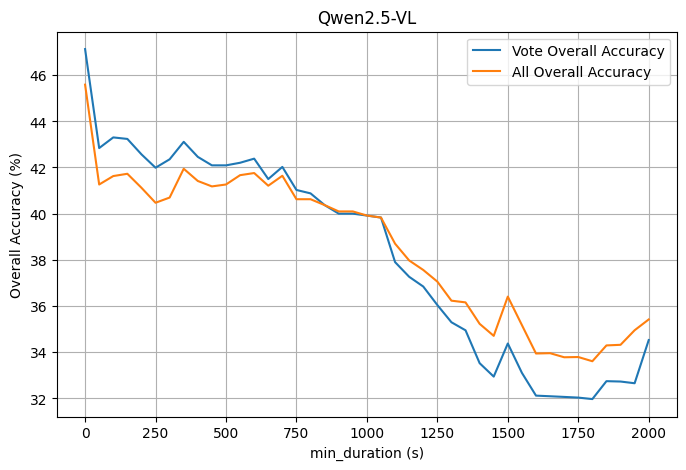

In [16]:
import json
import os
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt


def get_video_duration(video_path):
    import cv2
    if not os.path.exists(video_path):
        return None
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    video.release()
    if fps == 0:
        return None
    return frame_count / fps


def calculate_statistics(model_answers):
    results_vote = {
        'overall': {'correct': 0, 'total': 0},
    }
    results_all = {
        'overall': {'correct': 0, 'total': 0},
    }
    for answer in model_answers:
        from collections import Counter
        vote_content = Counter(
            answer["shuffle_model_answer_contents"]).most_common(1)[0][0]
        vote_correct = (vote_content == answer["shuffle_correct_contents"][-1])
        results_vote['overall']['total'] += 1
        if vote_correct:
            results_vote['overall']['correct'] += 1
        for model_content, correct_content in zip(answer["shuffle_model_answer_contents"], answer["shuffle_correct_contents"]):
            results_all['overall']['total'] += 1
            if model_content == correct_content:
                results_all['overall']['correct'] += 1
    return results_vote, results_all


def get_overall_acc(stats):
    if stats['overall']['total'] == 0:
        return 0.0
    return stats['overall']['correct'] / stats['overall']['total']


# 参数
input_file = "./evaluate/VLM/evaluation_output/qwen_full_shuffle/shuffle_results.json"
video_dir = "./clips/clips_resized/"

# 读取QA结果
with open(input_file, 'r', encoding='utf-8') as f:
    results = json.load(f)

# 预先缓存所有视频时长，避免重复读取
video_duration_dict = {}
import cv2
for qa_item in tqdm(results, desc="缓存视频时长"):
    match_id = qa_item["match_id"]
    event_type = qa_item["event_type"]
    qa_index = qa_item["index"]
    video_filename = f"{match_id}_{event_type}_{qa_index}.mp4"
    video_path = os.path.join(video_dir, match_id, video_filename)
    if video_path not in video_duration_dict:
        duration = get_video_duration(video_path)
        video_duration_dict[video_path] = duration

# 记录不同min_duration下的精度
min_durations = list(range(0, 2001, 50))
vote_acc_list = []
all_acc_list = []

for min_duration in tqdm(min_durations, desc="不同min_duration统计"):
    filtered_results = []
    for qa_item in results:
        match_id = qa_item["match_id"]
        event_type = qa_item["event_type"]
        qa_index = qa_item["index"]
        video_filename = f"{match_id}_{event_type}_{qa_index}.mp4"
        video_path = os.path.join(video_dir, match_id, video_filename)
        duration = video_duration_dict.get(video_path, None)
        if duration is not None and duration > min_duration:
            filtered_results.append(qa_item)
    results_vote, results_all = calculate_statistics(filtered_results)
    vote_acc = get_overall_acc(results_vote)
    all_acc = get_overall_acc(results_all)
    vote_acc_list.append(vote_acc)
    all_acc_list.append(all_acc)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(min_durations, [v * 100 for v in vote_acc_list],
         label="Vote Overall Accuracy")
plt.plot(min_durations, [v * 100 for v in all_acc_list],
         label="All Overall Accuracy")
plt.xlabel("min_duration (s)")
plt.ylabel("Overall Accuracy (%)")
plt.title("Qwen2.5-VL")
plt.legend()
plt.grid(True)
plt.show()

### 统计random acc

In [17]:
import os

path = './First_Half_QA/'
correct = 0
all = 0
for file in os.listdir(path):
    if file.endswith('.json'):
        with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
            data = json.load(f)
            for qa in data:
                all += 1
                correct += 1 / len(qa['choices'])

In [18]:
correct, all, correct / all

(394.75, 1428, 0.2764355742296919)